In [4]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io, color
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku
from skimage import data, filters
from ipywidgets import widgets
from scipy.ndimage import convolve
from skimage import exposure
from skimage.filters import threshold_mean


%matplotlib inline

    
def display_with_histogram(image, title):
    # pega parâmetros da imagem
    channels = image.shape[2] if len(image.shape) > 2 else 1
    is_colored = channels > 1

    # cria uma figura com espaço para a imagem e para o histograma
    figure, axes = plt.subplots(1, 2, figsize=(18, 5))
    image_axis, histogram_axis = axes

    # coloca a imagem em seu subplot
    image_axis.imshow(image, cmap='gray')
    image_axis.set_axis_off()
    image_axis.set_title('{} {}'.format(title, image.shape))

    # coloca o histograma em seu subplot
    if is_colored:
        channel_colors = ['red', 'green', 'blue']
        for i, c in enumerate(channel_colors):
            histogram_axis.hist(image[:, :, i].flatten(), bins=256, lw=1, color=c, histtype='step')
    else:
        histogram_axis.hist(image.ravel(), bins=256, lw=0, histtype='bar')
    histogram_axis.set_xlim(0, image.max())
    histogram_axis.set_yticks([])

    plt.show()


def display_all_images(images):
    # cria uma figura com espaço todas as imagens
    figure, axes = plt.subplots(2, 3, figsize=(18, 8))

    axes = axes.ravel()
    
    # coloca a imagem em seu subplot
    for i, image in enumerate(images):
        ax = axes[i]
        ax.imshow(image[1])
        ax.set_axis_off()
        ax.set_title(images[i][0])
        ax.plot()

    plt.show()
    

def display(image, title):
    figure = plt.imshow(image, cmap='gray')
    plt.axis('off')
    figure.axes.get_xaxis().set_visible(False)
    figure.axes.get_yaxis().set_visible(False)
    figure.axes.set_title('{} {}'.format(title, image.shape))
    plt.show()

def display_two_images(left, right, title=''):
    figure, axes = plt.subplots(1, 2, figsize=(18,8))
    left_ax, right_ax = axes

    left_ax.imshow(left)
    right_ax.imshow(right)
    
    left_ax.set_axis_off()
    right_ax.set_axis_off()
    
    plt.show()

## Imagens originais

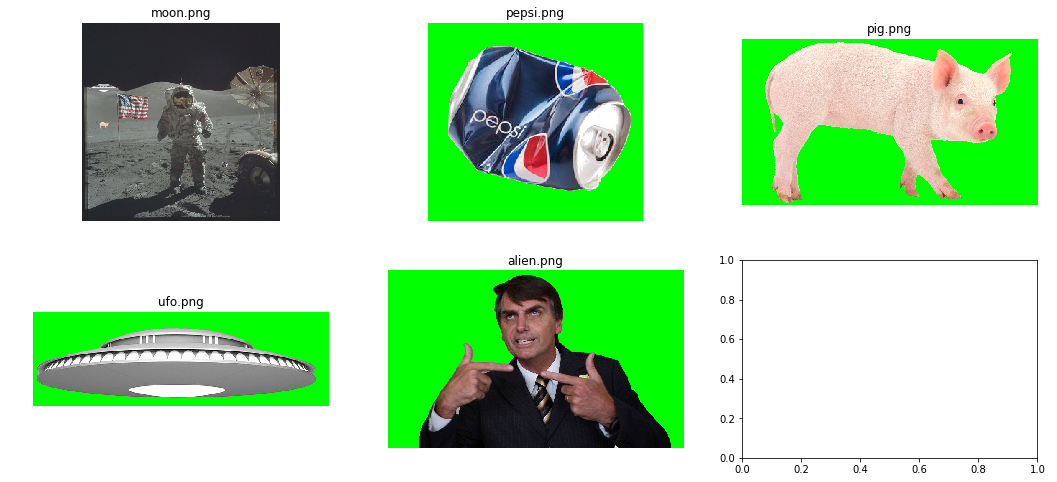

In [5]:
moon = skimage.img_as_float(io.imread("imagens/moon.png"))
pepsi = skimage.img_as_float(io.imread("imagens/pepsi.png"))
pig = skimage.img_as_float(io.imread("imagens/pig.png"))
ufo = skimage.img_as_float(io.imread("imagens/ufo.png"))
alien = skimage.img_as_float(io.imread("imagens/alien.png"))

display_all_images([
    ('moon.png', moon), 
    ('pepsi.png', pepsi),
    ('pig.png', pig),
    ('ufo.png', ufo),
    ('alien.png', alien)
])

## _Chroma keying_

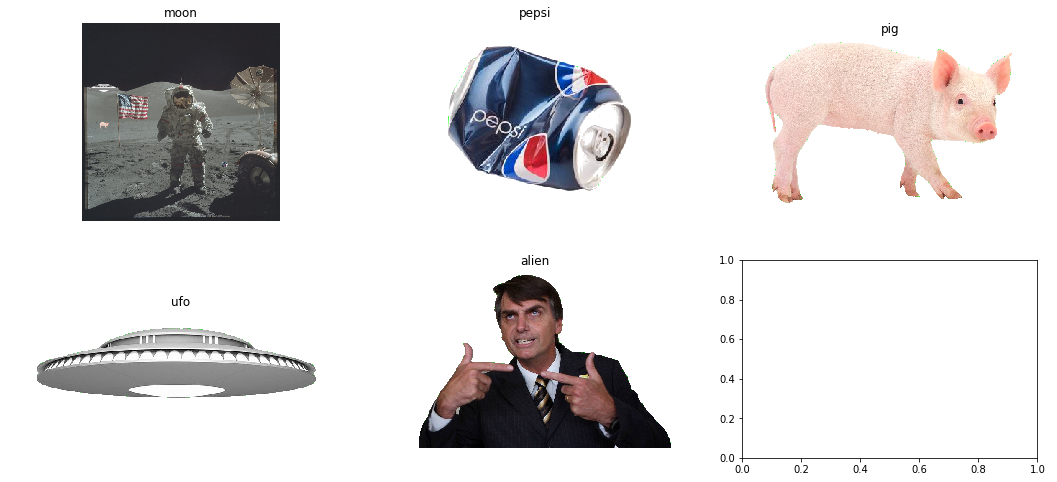

In [6]:
import numpy.ma as ma

def color_to_transparency(image, color, tolerance=0.25):
    '''
    Substitui uma cor da imagem RGBA por transparência.
    É utilizada uma tolerência de 25% em cada canal por padrão.
    '''
    masked_image = image.copy()
  
    reds = masked_image[:, :, 0]
    greens = masked_image[:, :, 1]
    blues = masked_image[:, :, 2]
    
    masked_reds = ma.masked_values(reds, color[0], atol=tolerance)
    masked_greens = ma.masked_values(greens, color[1], atol=tolerance)
    masked_blues = ma.masked_values(blues, color[2], atol=tolerance)
    masked_image[masked_reds.mask & masked_greens.mask & masked_blues.mask] = 0
    
    return masked_image



# tira o fundo das imagens
pepsi_transparent = color_to_transparency(pepsi, [0, 1, 0])
pig_transparent = color_to_transparency(pig, [0, 1, 0])
ufo_transparent = color_to_transparency(ufo, [0, 1, 0])
alien_transparent = color_to_transparency(alien, [0, 1, 0])


# mostra o resultado
display_all_images([
    ('moon', moon),
    ('pepsi', pepsi_transparent),
    ('pig', pig_transparent),
    ('ufo', ufo_transparent),
    ('alien', alien_transparent),
])

## Mesclagem de imagens

TODO